## App Store Reivew analysis - App name
---------------

## 개요

### 문서 목적
- **App name** 앱에 대한 분석 리포트 작성을 위해 문서를 만들었습니다.

### 분석 대상
- **구글 플레이 스토어에 고객이 작성한 리뷰 정보**
  - user_name : 이용자 이름(닉네임)
  - user_app_rating : 별점(1~5)
  - user_review_date : 리뷰 작성 날짜
  - company_comment_date : 답변 작성 날짜
  - comment : 리뷰 내용
  - company_answer_check : 답변 여부


### 분석 일시
- 데이터 분석 시작 : 분석 날짜
- 데이터 구성 날짜 : YYYY-MM-DD to YYYY-MM_DD
  - 2019년 이전의 데이터가 수집되더라도 분석 할 때는 2019년 01월 01일 이후의 데이터만 다룹니다.
  - 분석 목적이 앱에 대한 분석 리포트이며 빠르게 업데이트 되는 흐름에 맞추기 위해서 입니다.
  - 다만, 필요에 의해 수정 될 수 있습니다.

### 분석 방법
1. 데이터 확인
  - 데이터 전처리
  - 컬럼 확인
2. 시간 기록에 따른 데이터 분석
  - 시간에 따른 별점 변화(별점은 1 ~ 5의 값을 가진다)
  - 요일에 따른 리뷰 분석
  - 답변 시간차(고객 응대 소요 시간)
3. 리뷰 내용에 대한 자연어 분석
  - 리뷰 내용을 Topic modeling로 구성하고 시각화
  - 별점에 따라 주요 키워드 분석 진행

### 분석 환경, 분석자
- 분석 환경
  - language
      - python3
  - library
      - [khaiii](https://github.com/kakao/khaiii) : 카카오에서 제공하는 형태소 분석기
      - [gensim](https://radimrehurek.com/gensim/) : 자연어 처리 방법 중 LDA - Topic Modeling 사용
      - 시각화, 데이터 분석을 위한 Python library

- 분석자
  - github : https://github.com/timetobye


### 안내 사항
- **분석에 사용 될 리뷰 정보는 직접 크롤링**을 하여 데이터 셋을 구성하였습니다.
- 2018년 10월 한국 시장 기준으로 Android(72.2%) vs IOS(27.8%)의 점유율을 갖고 있어서 구글 플레이 스토어를 선택하였습니다.
  - [참고 링크 - Difference in Mobile OS Market Share is notable in US, Japan and South Korea](https://en.appa.pe/whitepaper/2018/)
  
--------------------------------------------

### 분석 결과

- 작성하기
----------------

### code

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.style as style
import seaborn as sns
import khaiii
import missingno as msno
import warnings
import re
import calendar
import gensim
import os
import pyLDAvis
from collections import Counter
from datetime import datetime
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from pyLDAvis import gensim as gensimvis
from pyLDAvis import display
from pyLDAvis import save_html as lda_visualization
from khaiii import KhaiiiApi
from matplotlib import font_manager, rc
apple = font_manager.FontProperties(fname = '/Library/Fonts/AppleGothic.ttf').get_name()
rc('font', family = apple)

warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
pyLDAvis.enable_notebook()
%matplotlib inline

## 1. 데이터 확인

### 데이터 전처리 - Preprocessing

In [2]:
# read_csv to make dataframe

google_playstore_user_review_orginal_df = pd.read_csv('tada_app_user_reviews_20191229_120905.csv')
google_playstore_user_review_orginal_df.head(10)

,user_name,user_app_rating,user_review_date,company_comment_date,user_comment,company_answer_check
0,김상희,5,2019년 12월 1일,no_answer,카카오택시보다 훨씬 좋아요 타다가 많이 생겼으면좋겠어요 기존이용하던걸 자꾸 멀리하는...,no_answer
1,Seulgi Jeong,5,2019년 12월 6일,no_answer,네... '타다 금지법'이 통과되기 직전이네요... 하지만 1년 6개월은 더 이용할...,no_answer
2,임윤성,5,2019년 12월 14일,no_answer,아직은 배차가 적어서 잘 안잡히는 것 같았지만 승차 거부도 없고 친절하게 와서 좋았...,no_answer
3,서현태,5,2019년 10월 6일,no_answer,"택시와의 차이점이 확연히 보입니다. 1. 자동결제로 빠른 승,하차 2. 친절한 기사...",no_answer
4,영현조,5,2019년 12월 28일,no_answer,없어지지마라진짜ㅠㅠ,no_answer
5,Youngchan Lee,5,2019년 12월 28일,no_answer,친절하고 편안합니다. 귀국시 연착되었는데도 불편한 기색 없었고 추가 요금도 요구하지...,no_answer
6,So-young Kim,5,2019년 12월 28일,no_answer,좋아요,no_answer
7,가즈아,5,2019년 12월 28일,no_answer,제발없어지지마라제발,no_answer
8,원미경,5,2019년 12월 27일,no_answer,늘 아이와 편안히 안심하고 탈 수 있어서 좋아요.,no_answer
9,안석현,5,2019년 12월 27일,no_answer,타다 영원하라,no_answer


In [3]:
# check dataframe info

google_playstore_user_review_orginal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 6 columns):
user_name               1821 non-null object
user_app_rating         1821 non-null int64
user_review_date        1821 non-null object
company_comment_date    1821 non-null object
user_comment            1821 non-null object
company_answer_check    1821 non-null object
dtypes: int64(1), object(5)
memory usage: 85.4+ KB


In [67]:
# google_playstore_user_review_orginal_df.rename(columns = {'comment' : 'user_comment'}, inplace=True)

### check-point

- 크롤링 과정에서도 첫 3개가 시간 순서 정렬과 관계없이 항상 고정된 값으로 구성되어 있었다.
  - 해당 부분에 대해서는 날짜 기준으로 정렬할 것
- 중복 값이 있는 경우를 방지하기 위해 중복 체크도 진행한다.
- 날짜 정보도 사용하기 쉽게 YYYY-MM-DD 형식으로 처리 할 것
- 요일 정보를 얻기 위해 작업을 진행 할 것

In [5]:
def sort_dataframe(df):
    sorted_df = df.sort_values(by='user_review_date', ascending=False).reset_index(drop=True)
    
    return sorted_df

def drop_duplicate_dataframe(df):
    drop_dp_df = df.drop_duplicates()
    drop_dp_df.reset_index(drop=True, inplace=True)
    
    return drop_dp_df

def get_weekday(date):
    if date == 'no_answer':
        return date
    
    weekday_info_dict = {
        0 : 'Mon',
        1 : 'Tue',
        2 : 'Wed',
        3 : 'Thu',
        4 : 'Fri',
        5 : 'Sat',
        6 : 'Sun'
    }
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)
    
    year, month, day = [int(value) for value in get_regex_date]
    
    weekday_number = calendar.weekday(year, month, day)
    weekday_value = weekday_info_dict[weekday_number]
    
    return weekday_value

def convert_date_format(date):
    if date == 'no_answer':
        return date
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)

    if len(get_regex_date[1]) == 1:
        get_regex_date[1] = '0' + get_regex_date[1]
        
    if len(get_regex_date[2]) == 1:
        get_regex_date[2] = '0' + get_regex_date[2]
    
    join_string = '-'
    convert_date = join_string.join(get_regex_date)
    
    return convert_date

def arrange_user_comment(df):
    df = df[['user_name', 'user_app_rating', 'user_review_date', 'company_comment_date', 'user_review_weekday', 'user_comment', 'company_answer_check']]
    df = df[df['user_review_date']>='2019-01-01']
    
    return df

def user_data_preprocessing(google_playstore_user_review_orginal_df):
    # sort user_review_date
    sorted_user_review_df = sort_dataframe(google_playstore_user_review_orginal_df)

    # drop duplicate
    drop_dp_user_review_df = drop_duplicate_dataframe(sorted_user_review_df)

    # get weekday from user_review_date
    drop_dp_user_review_df['user_review_weekday'] = drop_dp_user_review_df['user_review_date'].apply(get_weekday)

    # convert_date_format for applying function in pandas
    drop_dp_user_review_df['user_review_date'] = drop_dp_user_review_df['user_review_date'].apply(convert_date_format)
    drop_dp_user_review_df['company_comment_date'] = drop_dp_user_review_df['company_comment_date'].apply(convert_date_format)

    # arrange_user_comment
    arranged_user_review_df = arrange_user_comment(drop_dp_user_review_df)
    
    return arranged_user_review_df

In [6]:
arranged_user_review_df = user_data_preprocessing(google_playstore_user_review_orginal_df)
arranged_user_review_df.head()

,user_name,user_app_rating,user_review_date,company_comment_date,user_review_weekday,user_comment,company_answer_check
0,김현정,5,2019-09-09,no_answer,Mon,항상 도움받고 있어요 아이데리고 승차하기 너무 좋답니다,no_answer
1,김뿌잉,3,2019-09-09,no_answer,Mon,나이 좀 있으신 기사님 몇분은 아직도 핑계를 대며 배차취소를 유도하시네요. 이런분들...,no_answer
2,김민기,5,2019-09-08,no_answer,Sun,타다는 없어지면 안됩니다! 항상 응원합니다!,no_answer
3,ES K,1,2019-09-08,no_answer,Sun,이용할려고 했더니 요금이 너무 터무니없이 비싸네요 ㅠ,no_answer
4,옛사람,2,2019-09-08,no_answer,Sun,"중요한건 ~ 보험문제인데,, 본인이 직접하든ᆢ먼거리를 지인(가족ㆍ친구등)과 함께 졸...",no_answer


--------------------------------

## Basic EDA

### check data info & missingvalue

In [7]:
arranged_user_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1628 entries, 0 to 1627
Data columns (total 7 columns):
user_name               1628 non-null object
user_app_rating         1628 non-null int64
user_review_date        1628 non-null object
company_comment_date    1628 non-null object
user_review_weekday     1628 non-null object
user_comment            1628 non-null object
company_answer_check    1628 non-null object
dtypes: int64(1), object(6)
memory usage: 101.8+ KB


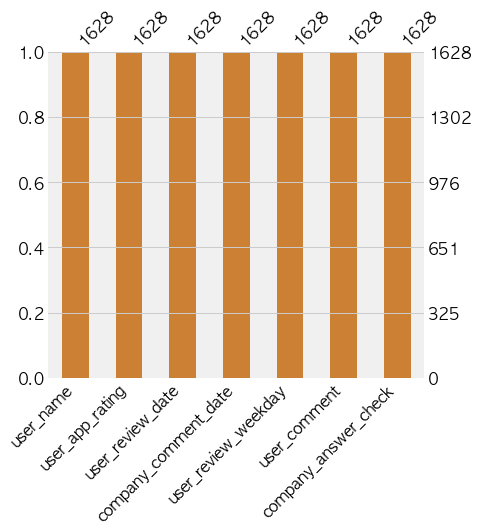

In [8]:
#msno.bar

msno.bar(df=arranged_user_review_df.iloc[:, :], figsize=(6, 6), color=(0.8, 0.5, 0.2))
plt.show()

### 수집된 데이터의 기간

In [9]:
max_date = arranged_user_review_df['user_review_date'].max()
min_date = arranged_user_review_df['user_review_date'].min()

print(f'수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 {min_date} 부터 {max_date} 까지 입니다.')

수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 2019-01-01 부터 2019-12-28 까지 입니다.


In [10]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('user').reset_index(name='writing_count')
    sorted_df_count = df_count.sort_values('writing_count', ascending=False)
    arranged_df = sorted_df_count.reset_index(drop=True)

    return arranged_df

### 어떤 요일에 많이 달았을까?

In [11]:
weekday_count = arrange_count_value(arranged_user_review_df, 'user_review_weekday')
weekday_count.rename(columns={'user' : 'weekday'}, inplace=True)

In [12]:
weekday_count

,weekday,writing_count
0,Mon,257
1,Tue,253
2,Wed,248
3,Thu,226
4,Sat,226
5,Sun,225
6,Fri,193


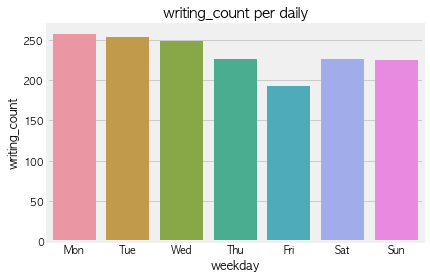

In [13]:
# draw weekday graph

weekday_order_list = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.barplot(x='weekday', y='writing_count', data=weekday_count, order=weekday_order_list)
plt.title('writing_count per daily')
plt.show()

## 요일에 따른 리뷰 분석

In [14]:
weekday_user_review_df = arranged_user_review_df[['user_app_rating', 'user_review_weekday']]
weekday_user_review_df.head()

,user_app_rating,user_review_weekday
0,5,Mon
1,3,Mon
2,5,Sun
3,1,Sun
4,2,Sun


In [15]:
# crosstab for checking two catagory

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], margins=True).style.background_gradient(cmap='summer_r')
crosstab_result

user_review_weekday,Fri,Mon,Sat,Sun,Thu,Tue,Wed,All
user_app_rating,,,,,,,,
1,20,17,18,18,31,32,26,162
2,3,4,2,1,4,5,1,20
3,3,5,6,5,3,2,3,27
4,4,5,8,4,12,8,9,50
5,163,226,192,197,176,206,209,1369
All,193,257,226,225,226,253,248,1628


In [16]:
# crosstab with ratio

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
crosstab_result

user_app_rating,1,2,3,4,5
user_review_weekday,,,,,
Fri,0.012285,0.001843,0.001843,0.002457,0.100123
Mon,0.010442,0.002457,0.003071,0.003071,0.138821
Sat,0.011057,0.001229,0.003686,0.004914,0.117936
Sun,0.011057,0.000614,0.003071,0.002457,0.121007
Thu,0.019042,0.002457,0.001843,0.007371,0.108108
Tue,0.019656,0.003071,0.001229,0.004914,0.126536
Wed,0.015971,0.000614,0.001843,0.005528,0.128378


In [17]:
def draw_heatmap(weekday_user_review_df, weekday_order_list):
    crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
    crosstab_result = crosstab_result.reindex(index=weekday_order_list)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(crosstab_result, cmap="YlGnBu", annot=True, cbar=True, fmt='0.3g')
    plt.title('user_app_rating per weekday')
    plt.show()

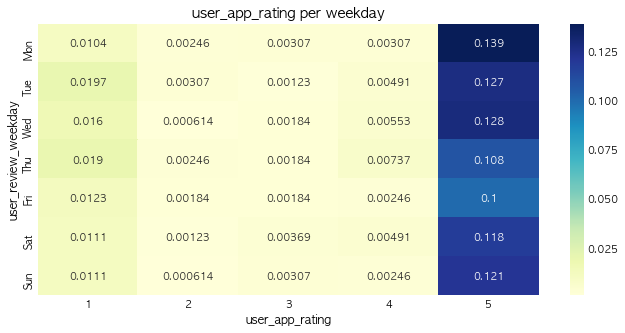

In [18]:
draw_heatmap(weekday_user_review_df, weekday_order_list)

### 리뷰를 작성한 사람들은 누구일까요?

In [19]:
arrange_count_df = arrange_count_value(arranged_user_review_df, 'user_name')
arrange_count_df.head(10)

,user,writing_count
0,Google 사용자,28
1,김태형,3
2,이주희,3
3,김수연,2
4,김소영,2
5,a k,2
6,이현석,2
7,김선우,2
8,김영진,2
9,김기현,2


- **Google 사용자**가 다수가 나온 이유를 살펴보니, 앱스토어에서 실제로 리뷰 작성자의 이름이 Google 사용자라고 되어 있다.
  - 탈퇴를 했거나, 혹은 익명의 아이디를 처리하는 방식으로 판단된다.
  - 결론적으로 Google 사용자를 잠시 제외하고 살펴보겠다.

In [20]:
drop_arrange_count_df = arrange_count_df[arrange_count_df['user']!='Google 사용자'].reset_index(drop=True)

# get user_review_count and ratio
groupby_user_review_count = drop_arrange_count_df.groupby('writing_count', as_index=False).count()
groupby_user_review_count.rename(columns = {'user' : 'count'}, inplace=True)
groupby_user_review_count['ratio'] = round(groupby_user_review_count['count']/sum(groupby_user_review_count['count']), 2)
groupby_user_review_count

,writing_count,count,ratio
0,1,1550,0.98
1,2,22,0.01
2,3,2,0.00


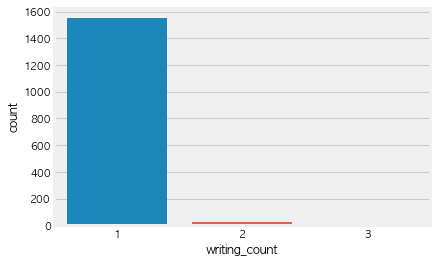

In [21]:
# 이용자들은 개인당 몇 번이나 리뷰를 달았을까?

sns.countplot(x='writing_count', data = drop_arrange_count_df)

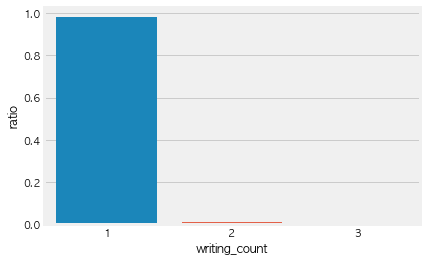

In [22]:
# 이용자들은 개인당 몇 번이나 리뷰를 달았을까?(비율)

sns.barplot(x='writing_count', y='ratio', data = groupby_user_review_count)

### 별점 분포는 어떻게 되어 있을까?

In [23]:
app_rating_count = arrange_count_value(arranged_user_review_df, 'user_app_rating')
app_rating_count.rename(columns={'user' : 'app_rating', 'writing_count' : 'rating_count'}, inplace=True)
app_rating_count

,app_rating,rating_count
0,5,1369
1,1,162
2,4,50
3,3,27
4,2,20


In [24]:
app_rating_count['ratio'] = round(app_rating_count['rating_count']/sum(app_rating_count['rating_count']), 2)
app_rating_count

,app_rating,rating_count,ratio
0,5,1369,0.84
1,1,162,0.10
2,4,50,0.03
3,3,27,0.02
4,2,20,0.01


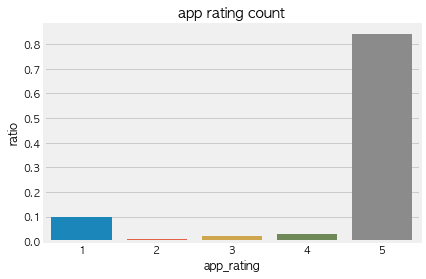

In [25]:
# draw app_rating graph

app_rating_order_list = [1, 2, 3, 4, 5]
sns.barplot(x='app_rating', y='ratio', data=app_rating_count, order=app_rating_order_list)
plt.title('app rating count')
plt.show()

-----------------------

## 2. 시간 기록에 따른 데이터 분석

### 시간에 따른 별점 변화
- 여러가지 접근 방법이 있겠지만, 일별 평균 별점 값을 그래프로 그려서 확인해본다.
- 2019년 01월 1일 이후만 확인

In [26]:
app_rating_with_date = arranged_user_review_df[['user_app_rating', 'user_review_date']]
average_app_rating_per_daily = app_rating_with_date.groupby('user_review_date', as_index=False).mean()
average_app_rating_per_daily = average_app_rating_per_daily[average_app_rating_per_daily['user_review_date']>='2019-01-01'] # defalt 2019-01-01
app_rating_with_date.head()

,user_app_rating,user_review_date
0,5,2019-09-09
1,3,2019-09-09
2,5,2019-09-08
3,1,2019-09-08
4,2,2019-09-08


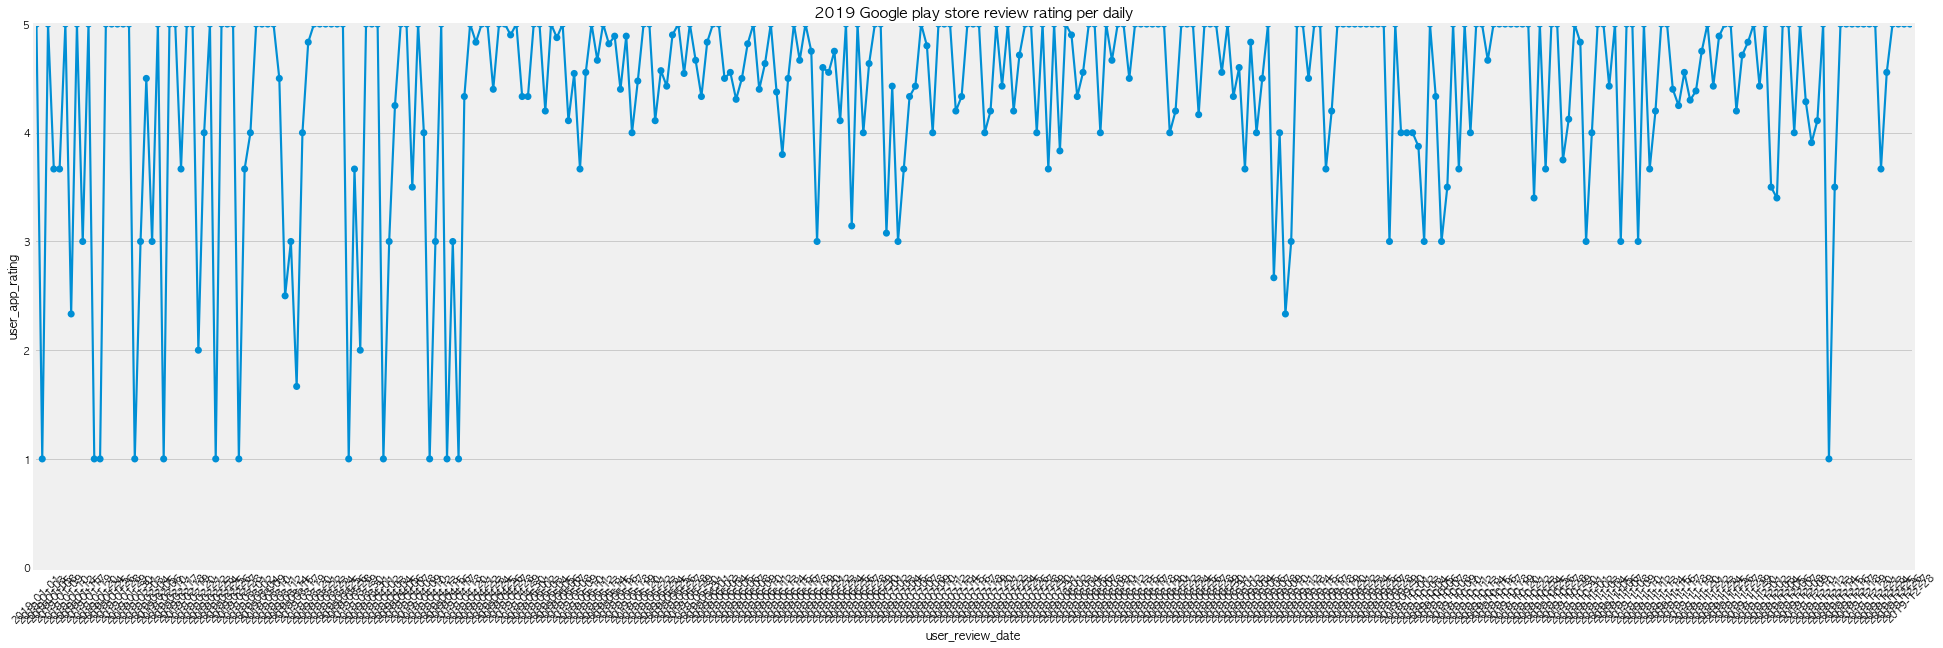

In [27]:
# draw graph : 2019 Google play store review rating per daily

plt.figure(figsize = (30, 10))
sns.pointplot(x='user_review_date', y='user_app_rating', data=average_app_rating_per_daily, scale=0.3)
plt.xticks(rotation=45)
plt.title('2019 Google play store review rating per daily', fontsize = 15)
plt.ylim(0, 5)
plt.show()

In [28]:
# check statics

app_rating_with_date.describe()

,user_app_rating
count,1628.000000
mean,4.501229
std,1.245767
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


### 월별 분석
- 월별 분석을 위해 간단한 전처리 진행 후 분석한다.

In [29]:
app_rating_with_monthly = arranged_user_review_df[['user_app_rating', 'user_review_date']]
app_rating_with_monthly.head()

,user_app_rating,user_review_date
0,5,2019-09-09
1,3,2019-09-09
2,5,2019-09-08
3,1,2019-09-08
4,2,2019-09-08


In [30]:
def extract_year_month(date):
    year_month = date[0:7]
    
    return year_month

In [31]:
app_rating_with_monthly['year_month'] = app_rating_with_monthly['user_review_date'].apply(extract_year_month)
app_rating_with_monthly.head()

,user_app_rating,user_review_date,year_month
0,5,2019-09-09,2019-09
1,3,2019-09-09,2019-09
2,5,2019-09-08,2019-09
3,1,2019-09-08,2019-09
4,2,2019-09-08,2019-09


In [32]:
app_rating_with_year_month = app_rating_with_monthly[(app_rating_with_monthly['year_month']>='2019-01')&(app_rating_with_monthly['year_month']<='2019-12')]
app_rating_with_year_month.sort_values('user_review_date', ascending=False, inplace=True)
app_rating_with_year_month.reset_index(drop=True, inplace=True)

In [33]:
app_rating_with_year_month.head()

,user_app_rating,user_review_date,year_month
0,5,2019-12-28,2019-12
1,5,2019-12-28,2019-12
2,5,2019-12-28,2019-12
3,5,2019-12-28,2019-12
4,5,2019-12-27,2019-12


In [34]:
monthly_result = app_rating_with_year_month.groupby('year_month', as_index=False).mean()
monthly_result

,year_month,user_app_rating
0,2019-01,3.620690
1,2019-02,3.933333
2,2019-03,4.280702
3,2019-04,4.539130
4,2019-05,4.674342
5,2019-06,4.571429
6,2019-07,4.426966
7,2019-08,4.729032
8,2019-09,4.385321
9,2019-10,4.342857


In [35]:
monthly_result.describe()

,user_app_rating
count,12.000000
mean,4.367122
std,0.312214
min,3.620690
25%,4.327318
50%,4.415864
75%,4.547205
max,4.729032


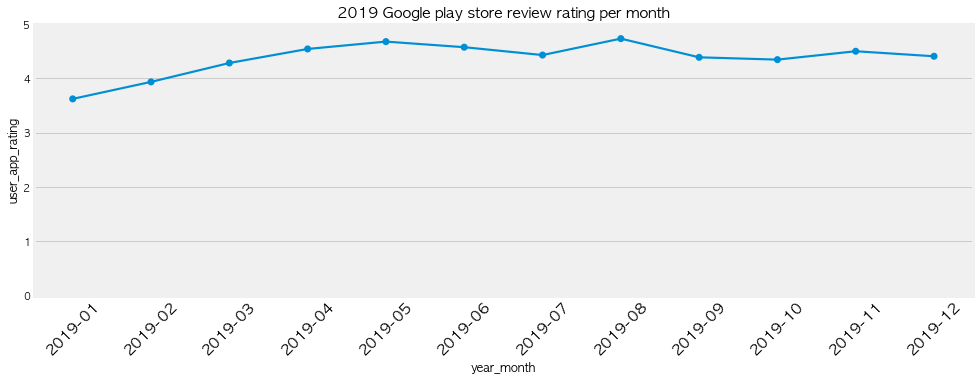

In [36]:
# draw graph : 2019 Google play store review rating per month

plt.figure(figsize = (15, 5))
sns.pointplot(x='year_month', y='user_app_rating', data=monthly_result, scale=0.3)
plt.xticks(rotation=45, fontsize = 15)
plt.title('2019 Google play store review rating per month', fontsize = 15)
plt.ylim(0, 5)
plt.show()

---------------------------------

### 답변 응답 비율
- 사용자의 리뷰에 꼭 답변을 달아야 할 필요는 없지만, 어느 정도는 필요할 것으로 보이기 때문에 이 항목을 살펴본다.
- 전체 평점과 평점이 2점 이하인 항목으로 나누어서 살펴본다.

In [37]:
def get_review_response_graph(series, title_type):
    if title_type == 'all':
        title_string = '전체 평점 리뷰 답변 비율'
    else:
        title_string = '2점 이하 평점 리뷰 답변 비율'
    
    plt.figure(figsize = (8, 5))
    sns.barplot(series.index, series.values)
    plt.title(title_string)
    plt.show()

In [38]:
review_response_all_rating = arranged_user_review_df['company_answer_check'].value_counts(normalize=True)
review_response_low_rating = arranged_user_review_df[arranged_user_review_df['user_app_rating']<=2]['company_answer_check'].value_counts(normalize=True)

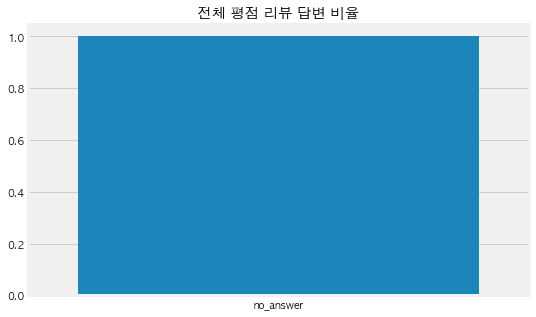

In [39]:
get_review_response_graph(review_response_all_rating, 'all')

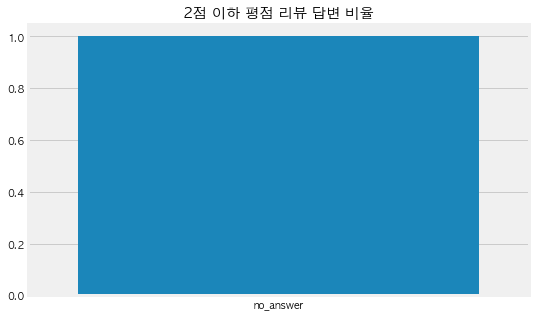

In [40]:
get_review_response_graph(review_response_low_rating, 'low')

### 리뷰에 답변이 얼마만에 달릴까?
- 이용자들에게 답변하는 날짜는 이용자가 리뷰를 달은 날짜와 얼마나 차이가 날까?
  - 답변을 달지 않은 날은 제외하고 파악해보도록 하자
  - 아쉽게도 시, 분, 초는 플레이스토어에서 구할 수가 없어서 day 기준으로 판단한다.
- 리플을 굳이 달지 않아도 되는 항목이 있을 수도 있으니, 리플을 달은 것 vs 달지 않은 것에 대한 비교는 하지 않는다.

In [41]:
reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_answer = reply_date_df[reply_date_df['company_comment_date']!='no_answer'].reset_index(drop=True)
reply_date_df_with_answer.head()

,user_app_rating,user_review_date,company_comment_date


In [42]:
def convert_string_to_datetime_format(date):
    convert_date = datetime.strptime(date, "%Y-%m-%d")
    
    return convert_date


def calculate_time_deleta(df, column_name_1, column_name2):
    time_delta_list = []
    for index, row in df.iterrows():
        time_delta_value = row[column_name2] - row[column_name_1]
        time_delta_day = time_delta_value.days
        
        time_delta_list.append(time_delta_day)
        
    df['reply_time'] = time_delta_list
    
    return df

In [43]:
# convert string to datetime_format

reply_date_df_with_answer_columns = ['user_review_date', 'company_comment_date']

for column in reply_date_df_with_answer_columns:
    reply_date_df_with_answer[column] = reply_date_df_with_answer[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_answer, 'user_review_date', 'company_comment_date')
cal_reply_time_delta_df.head()

,user_app_rating,user_review_date,company_comment_date,reply_time


In [44]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('reply_time').reset_index(name='count')
    sorted_df_count = df_count.sort_values('reply_time', ascending=True)
    arranged_df = sorted_df_count.reset_index(drop=True)
    arranged_df = sorted_df_count[sorted_df_count['reply_time']>=0].reset_index(drop=True)
    
    return arranged_df

In [45]:
# 답변 시간이 음수가 되는 경우가 종종 있다. 
# 시스템 문제로 파악 되었으나, 그게 아니고 하나의 글에 리플을 여러번 달 경우 처음 답변과의 시차가 발생해서 나타난 결과이다.
# 이번 분석에서는 음수가 되는 경우는 제외하고 시각화 하겠다.

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df = reply_time_df[reply_time_df['reply_time']<=20]

In [48]:
reply_time_df.head()

,reply_time,count,ratio,cumsum_ratio


### 응답한 내용이 없다.

In [49]:
# # draw reply_time graph
# def draw_count_and_ratio_graph(df):
#     y_position = 1.02
#     f, ax = plt.subplots(1,2, figsize=(20, 5))

#     sns.barplot(x='reply_time', y='count', data=df, ax=ax[0])
#     ax[0].set_title(f'reply_time with count')

#     sns.barplot(x='reply_time', y='cumsum_ratio', data=df, ax=ax[1])
#     ax[1].set_title(f'reply_time with cumsum_ratio')
    
#     plt.tight_layout()
#     plt.show()

# draw_count_and_ratio_graph(reply_time_df)

In [52]:
# # filter data set

# reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
# reply_date_df_with_low_rating = reply_date_df[(reply_date_df['company_comment_date']!='no_answer')&(reply_date_df['user_app_rating']<=2)].reset_index(drop=True)
# reply_date_df_with_low_rating.head()


# # convert string to datetime_format

# reply_date_df_with_low_rating_columns = list(reply_date_df_with_low_rating.columns)

# for column in reply_date_df_with_low_rating_columns:
#     if column == "user_app_rating":
#         continue

#     reply_date_df_with_low_rating[column] = reply_date_df_with_low_rating[column].apply(convert_string_to_datetime_format)
    

# # calculate time delta

# cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_low_rating, 'user_review_date', 'company_comment_date')


# # calculate ratio

# reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
# reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
# reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
# reply_time_df = reply_time_df[reply_time_df['reply_time']<=20]

In [53]:
# draw_count_and_ratio_graph(reply_time_df)

### 3. 리뷰 내용에 대한 자연어 간단 분석
- KAKAO KHAiii를 이용하여 명사 추출
- 추출된 자료를 바탕으로 Topic modeling로 구성하고 시각화
- 별점에 따라 주요 키워드 분석 진행

In [54]:
def extract_noun(word_object_list):
    extracted_word_noun_list = []
    
    for i, word_object in enumerate(word_object_list):
        word_object_morphs = word_object.morphs
        
        for word in word_object_morphs:
            if word.tag in ['NNG', 'NNP']:
                extracted_word_noun_list.append(word.lex)
    
    return extracted_word_noun_list


def execute_khaiii(user_comment_list):
    sentence_analyze_components = []
    kha_api = KhaiiiApi()
    
    for i, user_comment in enumerate(user_comment_list):
        word_object_list = []
        user_comment_analyze_objects = kha_api.analyze(user_comment)
        
        for user_comment_analyze_object in user_comment_analyze_objects:
            word_object_list.append(user_comment_analyze_object)
            
        extracted_noun_list = extract_noun(word_object_list)  
        sentence_analyze_components.append(extracted_noun_list)
        
#         if i == 1:
#             break
    
    return sentence_analyze_components

In [55]:
# get user_comment_noun_list of all rating reviews

user_comment_list = arranged_user_review_df['user_comment'].tolist()
all_rating_extracted_user_comment_noun_list = execute_khaiii(user_comment_list)

In [56]:
all_rating_extracted_user_comment_noun_list[0][0:10]

['도움', '아이데리', '승차']

In [57]:
def delete_stopwords(word):
    regex = '[ㄱ-ㅎㅏ-ㅣ]+'
    changed_word = re.sub(pattern=regex, repl='None', string=word)
    
    return changed_word

def get_dataframe_from_noun_list(extracted_user_comment_noun_list):
    word_count_dict = {}
    
    for i, word_list in enumerate(extracted_user_comment_noun_list):
        for word in word_list:
            if word not in word_count_dict:
                word_count_dict[word] = 1
            else:
                word_count_dict[word] += 1
                
    word_count_df = pd.DataFrame.from_dict(word_count_dict, orient='index').reset_index().rename(columns = {'index': 'word', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
    word_count_df['word'] = word_count_df['word'].apply(delete_stopwords)
    word_count_df_new = word_count_df[word_count_df['word']!='None']
    
    return word_count_df_new

def draw_graph(word_count_df_new):
    plt.figure(figsize = (15, 5))
    sns.barplot(x = 'word', y = 'count', data=word_count_df_new[0:15])
    plt.title('high frequency Top 15 words', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.show()

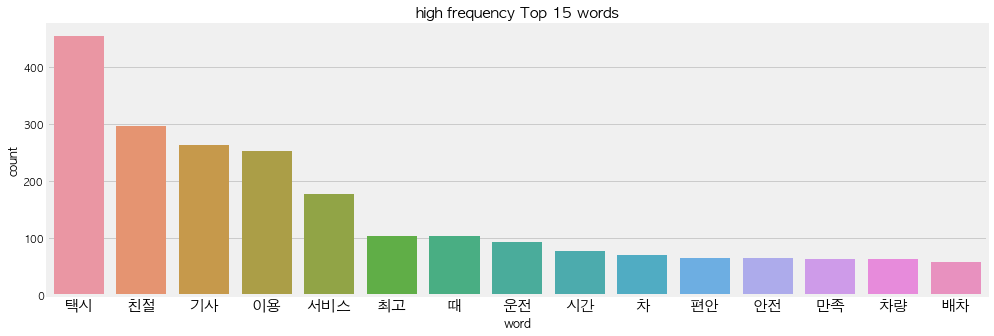

In [58]:
all_rating_word_count_df_new = get_dataframe_from_noun_list(all_rating_extracted_user_comment_noun_list)
draw_graph(all_rating_word_count_df_new)

In [59]:
# Topic Modeling with gensim

def save_model_data(name, directory_name):
    directory_path = f'{os.getcwd()}{os.sep}lda_model{os.sep}{directory_name}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    file_path = os.path.join(directory_path, name)

    return file_path


def load_model_data(name, directory_name):
    directory_path = f'{os.getcwd()}{os.sep}lda_model{os.sep}{directory_name}'
    file_path = os.path.join(directory_path, name)

    return file_path


class ReviewModeling:

    def __init__(self, topic_num=10, rating_type='all_rating'):
        self.topic_num = topic_num
        self.rating_type = rating_type

    def make_train_review_data_list(self, review_text_list):
        cleaned_articles = self._delete_single_word(review_text_list)
        high_frequency_words = self._get_high_frequency_words(cleaned_articles)
        data_list = self._filter_low_frequency_word(cleaned_articles, high_frequency_words)

        return data_list

    def make_lda_model(self, data_list):
        self._make_word_dictionary(data_list)
        self._make_doc_matrix(data_list)
        self._make_gensim_model()

    def make_lda_visualization(self):
        load_directory_name = f'{self.rating_type}'
        model_file_path = load_model_data('app_review_train_model.model', load_directory_name)
        model = LdaModel.load(model_file_path)
        
        dict_file_path = load_model_data('app_review_dict.dict', load_directory_name)
#         dict_file_path = f'lda_model{os.sep}{self.rating_type}{os.sep}app_review_dict.dict'
        dictionary = gensim.corpora.Dictionary.load(dict_file_path)
        
        corpus_file_path = load_model_data('app_review_corpus.mm', load_directory_name)
#         corpus_file_path = f'lda_model{os.sep}{self.rating_type}{os.sep}app_review_corpus.mm'
        corpus = gensim.corpora.MmCorpus(corpus_file_path)
        
        prepare_data = pyLDAvis.gensim.prepare(
            model, corpus, dictionary
        )

        html_file_name = f'{self.rating_type}_app_review_topic_modeling_visualization.html'
        lda_visualization(prepare_data, html_file_name)
        
        self._make_probability_graph(model)

    def _delete_single_word(self, article_list):
        article_num = 0
        for split_article in article_list:
            article_list[article_num] = list(filter(lambda x: len(x) >= 2, split_article))
            article_num += 1

        return article_list

    def _get_high_frequency_words(self, clean_text):
        article_words = Counter()
        for article in clean_text:
            article_words.update(article)

        common_words_set = article_words.most_common(10000)
        high_frequency_words_set = tuple(word for word, count in common_words_set)

        return high_frequency_words_set

    def _filter_low_frequency_word(self, article_list, high_frequency_words):
        article_num = 0
        compare_words_set = Counter(high_frequency_words)

        for article in article_list:
            count_result_list = []
            article_counter = Counter(article)
            count_result = article_counter & compare_words_set

            for word, value in count_result.items():
                count_result_list.append(word)
            article_list[article_num] = count_result_list
            article_num += 1

        return article_list

    def _make_word_dictionary(self, train_data):
        self.review_dictionary = corpora.Dictionary(train_data)
        
        directory_name = f'{self.rating_type}'
        review_dict_file_name = save_model_data('app_review_dict.dict', directory_name)
        self.review_dictionary.save(review_dict_file_name)

    def _make_doc_matrix(self, train_data):
        self.doc_matrix = []
        for doc in train_data:
            doc2bow_result = self.review_dictionary.doc2bow(doc)
            self.doc_matrix.append(doc2bow_result)
        
        directory_name = f'{self.rating_type}'
        doc_matrix_file_name = save_model_data('app_review_corpus.mm', directory_name)
        corpora.MmCorpus.serialize(doc_matrix_file_name, self.doc_matrix)

    def _make_gensim_model(self):
        review_lda = models.ldamodel.LdaModel
        model = review_lda(
            self.doc_matrix,
            num_topics=self.topic_num,
            id2word=self.review_dictionary,
            passes=100
        )
    
        directory_name = f'{self.rating_type}'
        model_file_name = save_model_data('app_review_train_model.model', directory_name)
        model.save(model_file_name)

        return model
    
    def _make_probability_graph(self, lda_model):
        fig = plt.figure(figsize=(20,30))
        number = self.topic_num
        image_file_name = f'{self.rating_type}_review_topic.png'
        for i in range(number):
            lda_model_dataframe=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')

            plt.subplot(5,3,i+1)
            sns.barplot(x='prob', y=lda_model_dataframe.index, data=lda_model_dataframe, label='Cities', palette="GnBu_d")
            plt.xlabel('probability')

        plt.tight_layout()
#         plt.savefig(image_file_name) # 그림 파일로 저장
        plt.show()

In [60]:
def make_lda_model_with_reviews(news_text, topic_num=10, rating_type='all_rating'):
    # make a lda model from news and draw a topic modeling graph.
    data = ReviewModeling(topic_num, rating_type)
    train_data_set = data.make_train_review_data_list(news_text)
    data.make_lda_model(train_data_set)
    data.make_lda_visualization()

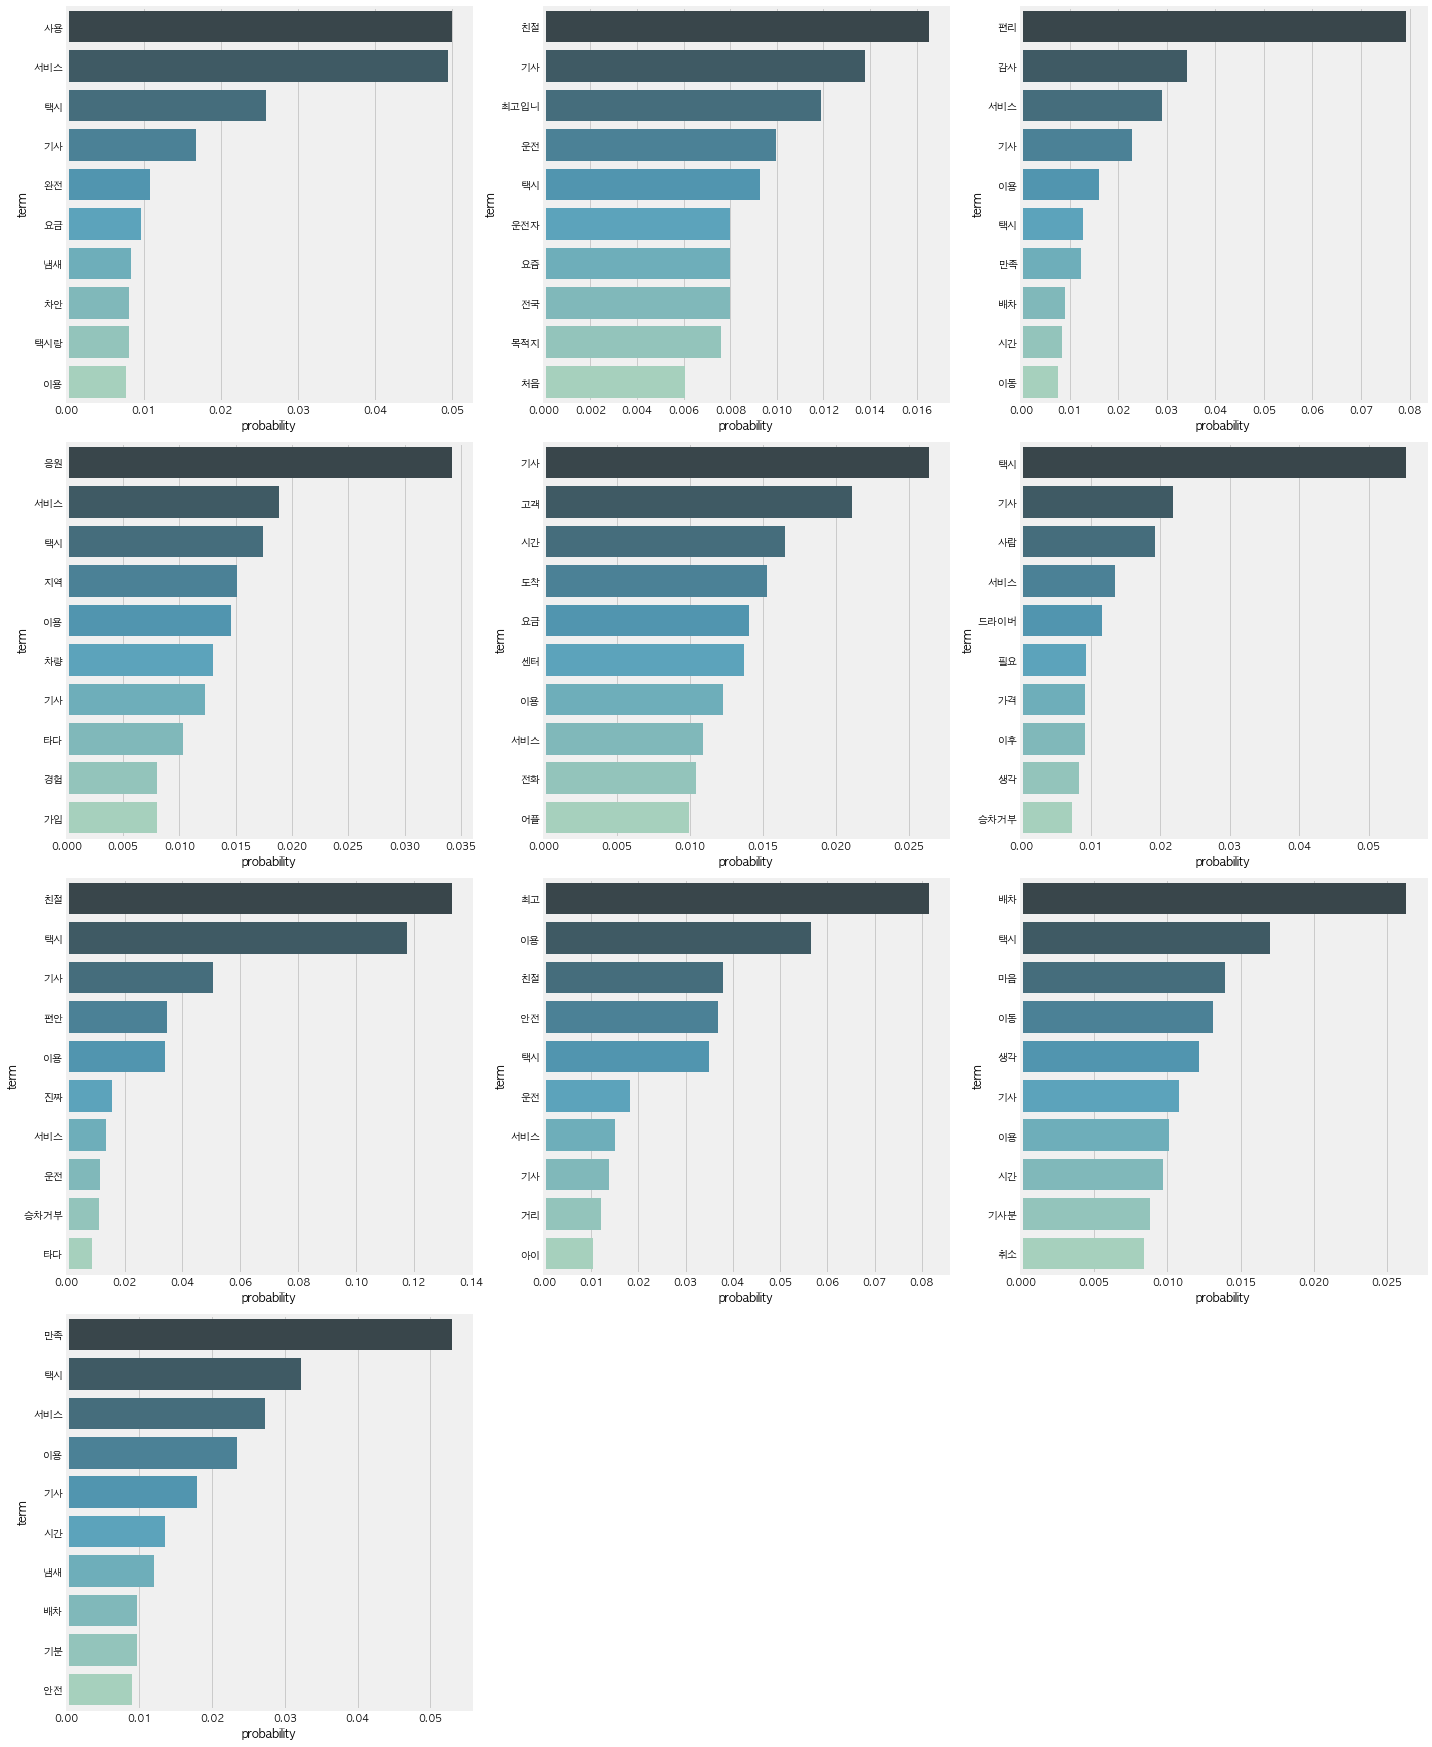

In [61]:
# run Topic modeling
make_lda_model_with_reviews(all_rating_extracted_user_comment_noun_list, 10, 'all_rating')

### display topics

In [62]:
def display_topics(app_rating):
    dictionary_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_dict.dict'
    corpus_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_corpus.mm'
    model_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_train_model.model'
    
    review_dictionary = gensim.corpora.Dictionary.load(dictionary_file_path)
    review_corpus = gensim.corpora.MmCorpus(corpus_file_path)
    review_lda = gensim.models.ldamodel.LdaModel.load(model_file_path)
    
    review_prep = pyLDAvis.gensim.prepare(review_lda, review_corpus, review_dictionary)
    
    return review_prep
    
review_prep = display_topics('all_rating')
pyLDAvis.display(review_prep)

### 별점 2점 이하일 경우에 대한 분석

In [63]:
# get user_comment_noun_list of low rating reviews

low_rating_user_comment_list = arranged_user_review_df[arranged_user_review_df['user_app_rating'] <= 2]['user_comment'].tolist()
low_rating_extracted_user_comment_noun_list = execute_khaiii(low_rating_user_comment_list)

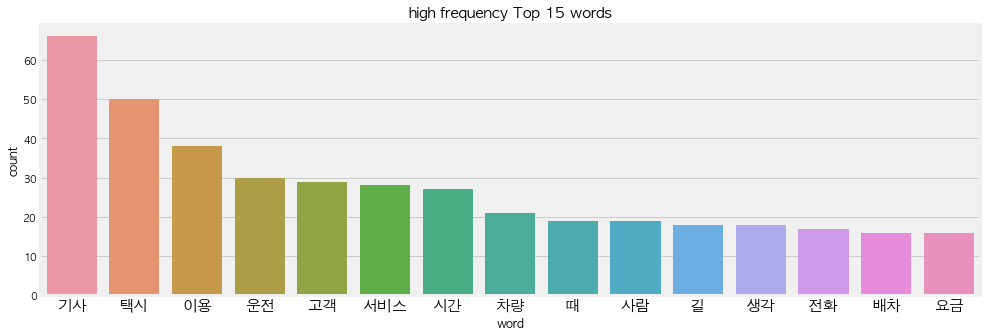

In [64]:
low_rating_word_count_df_new = get_dataframe_from_noun_list(low_rating_extracted_user_comment_noun_list)
draw_graph(low_rating_word_count_df_new)

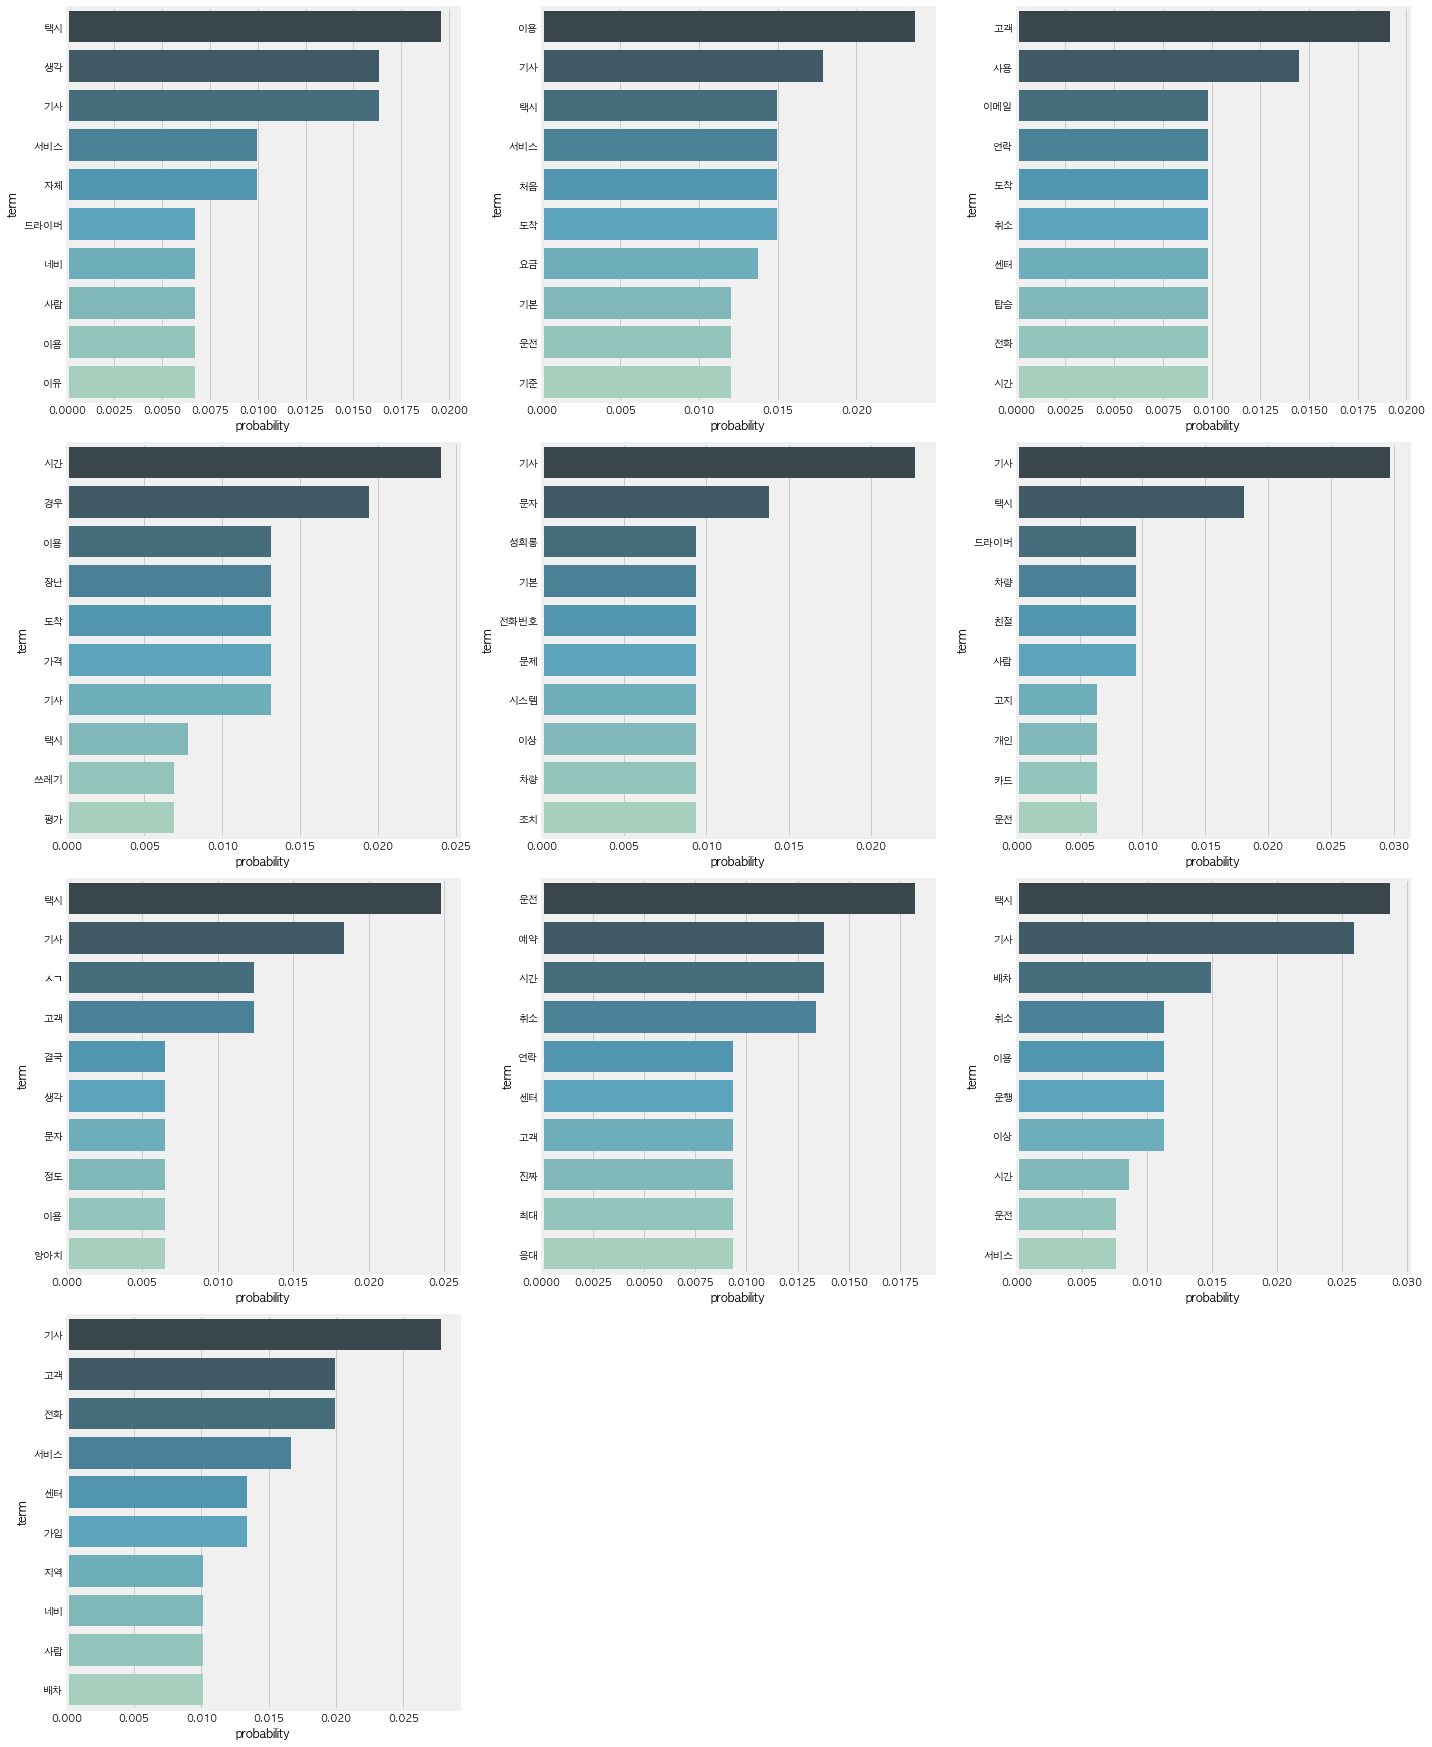

In [65]:
# run Topic modeling

make_lda_model_with_reviews(low_rating_extracted_user_comment_noun_list, 10, 'low_rating')

In [66]:
def display_topics(app_rating):
    dictionary_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_dict.dict'
    corpus_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_corpus.mm'
    model_file_path = f'lda_model{os.sep}{app_rating}{os.sep}app_review_train_model.model'
    
    review_dictionary = gensim.corpora.Dictionary.load(dictionary_file_path)
    review_corpus = gensim.corpora.MmCorpus(corpus_file_path)
    review_lda = gensim.models.ldamodel.LdaModel.load(model_file_path)
    
    review_prep = pyLDAvis.gensim.prepare(review_lda, review_corpus, review_dictionary)
    
    return review_prep
    
review_prep = display_topics('low_rating')
pyLDAvis.display(review_prep)